In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8),
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from pathlib import Path
from keras import backend, layers, activations, Model

from amp.utils.basic_model_serializer import load_master_model_components
from amp.models.decoders import amp_expanded_decoder
from amp.models.encoders import amp_expanded_encoder
from amp.models.master import master
from amp.utils import basic_model_serializer
import amp.data_utils.data_loader as data_loader
from amp.data_utils.sequence import pad, to_one_hot



from tqdm import tqdm
from joblib import dump, load
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
params = {'axes.labelsize': 16,
         'axes.titlesize': 24,
         'xtick.labelsize':14,
         'ytick.labelsize': 14}
plt.rcParams.update(params)
plt.rc('text', usetex=False)
sns.set_style('whitegrid', {'grid.color': '.95', 'axes.spines.right': False, 'axes.spines.top': False})
sns.set_context("notebook")

Using TensorFlow backend.


In [3]:
seed = 7
np.random.seed(seed)

In [4]:
from amp.config import MIN_LENGTH, MAX_LENGTH, LATENT_DIM, MIN_KL, RCL_WEIGHT, HIDDEN_DIM, MAX_TEMPERATURE

input_to_encoder = layers.Input(shape=(MAX_LENGTH,))
input_to_decoder = layers.Input(shape=(LATENT_DIM+2,))

In [5]:
def translate_generated_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el - 1] if el != 0 else "" for el in encoded_peptide[0].argmax(axis=1)])

def translate_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el-1] if el != 0 else "" for el in encoded_peptide])

In [6]:
models = [
    'HydrAMP',
    'PepCVAE',
    'Basic',
]

model_labels = [
    'HydrAMP',
    'PepCVAE',
    'Basic',
]

In [7]:
bms = basic_model_serializer.BasicModelSerializer()
amp_classifier = bms.load_model('../models/amp_classifier')
amp_classifier_model = amp_classifier()
mic_classifier = bms.load_model('../models/mic_classifier/')
mic_classifier_model = mic_classifier() 

# Get validation data

In [8]:
data_manager = data_loader.AMPDataManager(
    '../data/unlabelled_positive.csv',
    '../data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y = data_manager.get_merged_data()
amp_x_train, amp_x_test, amp_y_train, amp_y_test = train_test_split(amp_x, amp_y, test_size=0.1, random_state=36)
amp_x_train, amp_x_val, amp_y_train, amp_y_val = train_test_split(amp_x_train, amp_y_train, test_size=0.2, random_state=36)

In [9]:
# Restrict the length
ecoli_df = pd.read_csv('../data/mic_data.csv')
mask = (ecoli_df['sequence'].str.len() <= MAX_LENGTH) & (ecoli_df['sequence'].str.len() >= MIN_LENGTH)
ecoli_df = ecoli_df.loc[mask]
mic_x = pad(to_one_hot(ecoli_df['sequence']))
mic_y = ecoli_df.value

mic_x_train, mic_x_test, mic_y_train, mic_y_test = train_test_split(mic_x, mic_y, test_size=0.1, random_state=36)
mic_x_train, mic_x_val, mic_y_train, mic_y_val = train_test_split(mic_x_train, mic_y_train, test_size=0.2, random_state=36)

In [10]:
pos = np.vstack([amp_x_val[amp_y_val == 1], mic_x_val[mic_y_val < 1.5]])
neg = np.vstack([amp_x_val[amp_y_val == 0], mic_x_val[mic_y_val > 1.5]])

In [11]:
neg.shape, pos.shape

((2223, 25), (2404, 25))

In [12]:
pos_amp = amp_classifier_model.predict(pos, verbose=1).reshape(len(pos))
neg_mic = mic_classifier_model.predict(neg, verbose=1).reshape(len(neg))
neg_amp = amp_classifier_model.predict(neg, verbose=1).reshape(len(neg))
pos_mic = mic_classifier_model.predict(pos, verbose=1).reshape(len(pos))

2404/2404 [==============================] - 0s 44us/step


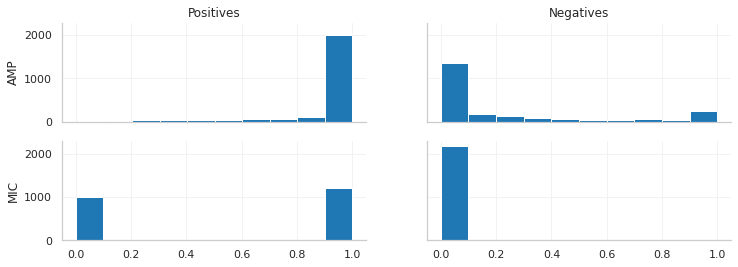

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 4), sharex=True, sharey=True) 
ax1.hist(pos_amp)
ax1.set_ylabel('AMP')
ax1.set_title('Positives')
ax2.hist(neg_amp)
ax2.set_title('Negatives')

ax3.hist(pos_mic)
ax3.set_ylabel('MIC')
ax4.hist(neg_mic)
plt.show()

In [14]:
pos = np.vstack([pos] * 64).reshape(-1, 25)
pos_amp = np.vstack([pos_amp] * 64).reshape(-1, 1)
pos_mic = np.vstack([pos_mic] * 64).reshape(-1, 1)
neg = np.vstack([neg] * 64).reshape(-1, 25)
neg_amp = np.vstack([neg_amp] * 64).reshape(-1, 1)
neg_mic = np.vstack([neg_mic] * 64).reshape(-1, 1)

In [15]:
def improve(x, model, epoch, mode):
    if mode == 'pos':
        amp = pos_amp
        mic = pos_mic
    else:
        amp = neg_mic
        mic = neg_mic
        
    encoded = encoder_model.predict(x, batch_size=5000)
    conditioned = np.hstack([
        encoded,
        np.ones((len(x), 1)),
        np.ones((len(x), 1)),
    ])
    decoded = decoder_model.predict(conditioned, batch_size=5000)
    new_peptides = np.argmax(decoded, axis=2)
    new_amp = amp_classifier_model.predict(new_peptides, batch_size=5000)
    new_mic = mic_classifier_model.predict(new_peptides, batch_size=5000)                                                                             
    
    # RELATIVE
    rel_better = new_amp > amp.reshape(-1, 1)
    rel_better = rel_better & (new_mic > mic.reshape(-1, 1))
    rel_better = np.logical_or.reduce(rel_better, axis=1)
    rel_improved = new_peptides[np.where(rel_better), :].reshape(-1, 25)
    before_rel_improve = x[np.where(rel_better), :].reshape(-1, 25)
    
    # ABSOLUTE
    abs_better = new_amp >= 0.8
    abs_better = abs_better & (new_mic > 0.5)
    abs_better = np.logical_or.reduce(abs_better, axis=1)
    abs_improved = new_peptides[np.where(abs_better), :].reshape(-1, 25)
    before_abs_improve = x[np.where(abs_better), :].reshape(-1, 25)
    
    return {
        'new_peptides': new_peptides,
        'rel_improved': rel_improved,
        'abs_improved': abs_improved,
        'before_rel_improve': before_rel_improve,
        'before_abs_improve': before_abs_improve, 
        'new_amp': new_amp,
        'new_mic': new_mic,
        }                                                                             

# HydrAMP improve

In [16]:
from keras.models import Model
model = models[0]
current_model_pos = {epoch: [] for epoch in range(40)} 
current_model_neg = {epoch: [] for epoch in range(40)}    
for epoch in tqdm(range(40)):
        AMPMaster = bms.load_model(f'../models/{model}/{epoch}')
        encoder_model =  AMPMaster.encoder(input_to_encoder)
        decoder_model = AMPMaster.decoder(input_to_decoder)         
        current_model_pos[epoch] = improve(pos, model, epoch, 'pos')
        current_model_neg[epoch] = improve(neg, model, epoch, 'neg')
dump(current_model_pos, f'../results/improvement_PosVal_{model}.joblib') 
dump(current_model_neg, f'../results/improvement_NegVal_{model}.joblib') 


  0%|          | 0/40 [00:00<?, ?it/s]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=2.0> temperature


  2%|▎         | 1/40 [00:08<05:22,  8.26s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.9800997> temperature


  5%|▌         | 2/40 [00:16<05:13,  8.25s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.940891> temperature


  8%|▊         | 3/40 [00:24<05:06,  8.29s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.8835291> temperature


 10%|█         | 4/40 [00:33<05:00,  8.35s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.8096749> temperature


 12%|█▎        | 5/40 [00:42<04:55,  8.44s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.721416> temperature


 15%|█▌        | 6/40 [00:50<04:50,  8.55s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.6211685> temperature


 18%|█▊        | 7/40 [00:59<04:45,  8.67s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.5115675> temperature


 20%|██        | 8/40 [01:08<04:41,  8.80s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.3953526> temperature


 22%|██▎       | 9/40 [01:18<04:39,  9.01s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.2752563> temperature


 25%|██▌       | 10/40 [01:27<04:33,  9.11s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.1538996> temperature


 28%|██▊       | 11/40 [01:37<04:27,  9.23s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.0337026> temperature


 30%|███       | 12/40 [01:47<04:24,  9.44s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.91681194> temperature


 32%|███▎      | 13/40 [02:08<05:55, 13.15s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.8050484> temperature


 35%|███▌      | 14/40 [02:20<05:30, 12.70s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.6998755> temperature


 38%|███▊      | 15/40 [02:39<06:06, 14.66s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.6023884> temperature


 40%|████      | 16/40 [02:51<05:33, 13.88s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.5133215> temperature


 42%|████▎     | 17/40 [03:03<05:05, 13.28s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.43307132> temperature


 45%|████▌     | 18/40 [03:16<04:46, 13.04s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.36173156> temperature


 48%|████▊     | 19/40 [03:28<04:27, 12.74s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.2991372> temperature


 50%|█████     | 20/40 [03:41<04:17, 12.88s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.24491283> temperature


 52%|█████▎    | 21/40 [03:54<04:07, 13.02s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.19852248> temperature


 55%|█████▌    | 22/40 [04:08<03:58, 13.25s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.15931801> temperature


 57%|█████▊    | 23/40 [04:21<03:45, 13.26s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.12658352> temperature


 60%|██████    | 24/40 [04:34<03:30, 13.18s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 62%|██████▎   | 25/40 [04:48<03:18, 13.23s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 65%|██████▌   | 26/40 [05:02<03:08, 13.47s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 68%|██████▊   | 27/40 [05:16<02:58, 13.72s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 70%|███████   | 28/40 [05:30<02:46, 13.88s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 72%|███████▎  | 29/40 [05:45<02:36, 14.21s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 75%|███████▌  | 30/40 [06:00<02:24, 14.42s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 78%|███████▊  | 31/40 [06:15<02:11, 14.65s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 80%|████████  | 32/40 [06:31<01:59, 14.99s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 82%|████████▎ | 33/40 [06:47<01:46, 15.20s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 85%|████████▌ | 34/40 [07:03<01:33, 15.54s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 88%|████████▊ | 35/40 [07:20<01:18, 15.78s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 90%|█████████ | 36/40 [07:36<01:03, 15.89s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 92%|█████████▎| 37/40 [07:53<00:48, 16.24s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 95%|█████████▌| 38/40 [08:09<00:32, 16.25s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 98%|█████████▊| 39/40 [08:27<00:16, 16.66s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


100%|██████████| 40/40 [08:44<00:00, 13.11s/it]


['../results/improvement_NegVal_HydrAMP.joblib']

# PepCVAE improve

In [17]:
from keras.models import Model
model = models[1]
current_model_pos = {epoch: [] for epoch in range(40)} 
current_model_neg = {epoch: [] for epoch in range(40)}    
for epoch in tqdm(range(40)):
        AMPMaster = bms.load_model(f'../models/{model}/{epoch}')
        encoder_model =  AMPMaster.encoder(input_to_encoder)
        decoder_model = AMPMaster.decoder(input_to_decoder)
        new_act = layers.TimeDistributed(
            layers.Activation(activations.softmax),
            name='decoder_time_distribute_activation')
        decoder_model.layers.pop()
        x = new_act(decoder_model.layers[-1].output)
        decoder_model = Model(input=decoder_model.input, output=[x])            
        current_model_pos[epoch] = improve(pos, model, epoch, 'pos')
        current_model_neg[epoch] = improve(neg, model, epoch, 'neg')
dump(current_model_pos, f'../results/improvement_PosVal_{model}.joblib') 
dump(current_model_neg, f'../results/improvement_NegVal_{model}.joblib') 


  0%|          | 0/40 [00:00<?, ?it/s]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=2.0> temperature


  2%|▎         | 1/40 [00:16<10:32, 16.23s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.9800997> temperature


  5%|▌         | 2/40 [00:33<10:31, 16.63s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.940891> temperature


  8%|▊         | 3/40 [00:51<10:31, 17.06s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.8835291> temperature


 10%|█         | 4/40 [01:09<10:15, 17.11s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.8096749> temperature


 12%|█▎        | 5/40 [01:28<10:18, 17.67s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.721416> temperature


 15%|█▌        | 6/40 [01:47<10:13, 18.05s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.6211685> temperature


 18%|█▊        | 7/40 [02:05<09:58, 18.14s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.5115675> temperature


 20%|██        | 8/40 [02:26<10:05, 18.93s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.3953526> temperature


 22%|██▎       | 9/40 [02:45<09:54, 19.17s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.2752563> temperature


 25%|██▌       | 10/40 [03:05<09:37, 19.26s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.1538996> temperature


 28%|██▊       | 11/40 [03:24<09:15, 19.17s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.0337026> temperature


 30%|███       | 12/40 [03:44<09:07, 19.55s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.91681194> temperature


 32%|███▎      | 13/40 [04:05<08:54, 19.80s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.8050484> temperature


 35%|███▌      | 14/40 [04:26<08:48, 20.34s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.6998755> temperature


 38%|███▊      | 15/40 [04:46<08:26, 20.27s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.6023884> temperature


 40%|████      | 16/40 [05:08<08:18, 20.78s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.5133215> temperature


 42%|████▎     | 17/40 [05:31<08:08, 21.25s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.43307132> temperature


 45%|████▌     | 18/40 [05:53<07:57, 21.71s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.36173156> temperature


 48%|████▊     | 19/40 [06:16<07:38, 21.85s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.2991372> temperature


 50%|█████     | 20/40 [06:38<07:20, 22.03s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.24491283> temperature


 52%|█████▎    | 21/40 [07:01<07:05, 22.41s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.19852248> temperature


 55%|█████▌    | 22/40 [07:24<06:46, 22.57s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.15931801> temperature


 57%|█████▊    | 23/40 [07:49<06:32, 23.11s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.12658352> temperature


 60%|██████    | 24/40 [08:11<06:03, 22.74s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 62%|██████▎   | 25/40 [08:34<05:45, 23.04s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 65%|██████▌   | 26/40 [08:58<05:27, 23.36s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 68%|██████▊   | 27/40 [09:23<05:08, 23.71s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 70%|███████   | 28/40 [09:48<04:49, 24.14s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 72%|███████▎  | 29/40 [10:13<04:28, 24.44s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 75%|███████▌  | 30/40 [10:41<04:13, 25.37s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 78%|███████▊  | 31/40 [11:06<03:48, 25.42s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 80%|████████  | 32/40 [11:32<03:24, 25.59s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 82%|████████▎ | 33/40 [11:57<02:57, 25.32s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 85%|████████▌ | 34/40 [12:23<02:32, 25.47s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 88%|████████▊ | 35/40 [12:50<02:10, 26.02s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 90%|█████████ | 36/40 [13:16<01:44, 26.14s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 92%|█████████▎| 37/40 [13:43<01:18, 26.14s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 95%|█████████▌| 38/40 [14:10<00:53, 26.56s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 98%|█████████▊| 39/40 [14:39<00:27, 27.23s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


100%|██████████| 40/40 [15:07<00:00, 22.69s/it]


['../results/improvement_NegVal_PepCVAE.joblib']

# Basic improvement

In [18]:
from keras.models import Model
model = models[2]
current_model_pos = {epoch: [] for epoch in range(40)} 
current_model_neg = {epoch: [] for epoch in range(40)}    
for epoch in tqdm(range(40)):
        AMPMaster = bms.load_model(f'../models/{model}/{epoch}')
        encoder_model =  AMPMaster.encoder(input_to_encoder)
        decoder_model = AMPMaster.decoder(input_to_decoder)
        new_act = layers.TimeDistributed(
            layers.Activation(activations.softmax),
            name='decoder_time_distribute_activation')
        decoder_model.layers.pop()
        x = new_act(decoder_model.layers[-1].output)
        decoder_model = Model(input=decoder_model.input, output=[x])            
        current_model_pos[epoch] = improve(pos, model, epoch, 'pos')
        current_model_neg[epoch] = improve(neg, model, epoch, 'neg')
dump(current_model_pos, f'../results/improvement_PosVal_{model}.joblib') 
dump(current_model_neg, f'../results/improvement_NegVal_{model}.joblib') 


  0%|          | 0/40 [00:00<?, ?it/s]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=2.0> temperature


  2%|▎         | 1/40 [00:28<18:36, 28.62s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.9800997> temperature


  5%|▌         | 2/40 [01:05<19:40, 31.06s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.940891> temperature


  8%|▊         | 3/40 [01:34<18:46, 30.46s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.8835291> temperature


 10%|█         | 4/40 [02:05<18:22, 30.62s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.8096749> temperature


 12%|█▎        | 5/40 [02:36<17:52, 30.66s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.721416> temperature


 15%|█▌        | 6/40 [03:06<17:23, 30.68s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.6211685> temperature


 18%|█▊        | 7/40 [03:39<17:07, 31.15s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.5115675> temperature


 20%|██        | 8/40 [04:11<16:52, 31.66s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.3953526> temperature


 22%|██▎       | 9/40 [04:46<16:44, 32.40s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.2752563> temperature


 25%|██▌       | 10/40 [05:19<16:23, 32.80s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.1538996> temperature


 28%|██▊       | 11/40 [05:54<16:03, 33.21s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.0337026> temperature


 30%|███       | 12/40 [06:31<16:08, 34.60s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.91681194> temperature


 32%|███▎      | 13/40 [07:03<15:13, 33.83s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.8050484> temperature


 35%|███▌      | 14/40 [07:37<14:39, 33.83s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.6998755> temperature


 38%|███▊      | 15/40 [08:12<14:12, 34.11s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.6023884> temperature


 40%|████      | 16/40 [08:52<14:21, 35.91s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.5133215> temperature


 42%|████▎     | 17/40 [09:29<13:51, 36.15s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.43307132> temperature


 45%|████▌     | 18/40 [10:09<13:41, 37.33s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.36173156> temperature


 48%|████▊     | 19/40 [10:43<12:45, 36.45s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.2991372> temperature


 50%|█████     | 20/40 [11:53<15:27, 46.39s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.24491283> temperature


 52%|█████▎    | 21/40 [12:37<14:28, 45.72s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.19852248> temperature


 55%|█████▌    | 22/40 [13:09<12:28, 41.57s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.15931801> temperature


 57%|█████▊    | 23/40 [13:42<11:04, 39.08s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.12658352> temperature


 60%|██████    | 24/40 [14:15<09:53, 37.12s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 62%|██████▎   | 25/40 [14:46<08:49, 35.29s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 65%|██████▌   | 26/40 [15:19<08:05, 34.68s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 68%|██████▊   | 27/40 [15:52<07:23, 34.13s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 70%|███████   | 28/40 [16:24<06:43, 33.65s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 72%|███████▎  | 29/40 [17:04<06:31, 35.57s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 75%|███████▌  | 30/40 [17:47<06:17, 37.77s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 78%|███████▊  | 31/40 [18:24<05:37, 37.46s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 80%|████████  | 32/40 [18:59<04:54, 36.78s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 82%|████████▎ | 33/40 [19:35<04:14, 36.35s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 85%|████████▌ | 34/40 [20:10<03:36, 36.08s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 88%|████████▊ | 35/40 [20:46<03:00, 36.03s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 90%|█████████ | 36/40 [21:22<02:24, 36.10s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 92%|█████████▎| 37/40 [21:57<01:47, 35.69s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 95%|█████████▌| 38/40 [22:41<01:16, 38.20s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 98%|█████████▊| 39/40 [23:18<00:37, 37.97s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


100%|██████████| 40/40 [23:56<00:00, 35.91s/it]


['../results/improvement_NegVal_Basic.joblib']

# Collect results

In [30]:
pos_final_results =  {model: {epoch: 
                          {'absolute improvement':0,
                           'relative improvement':0,
                          } for epoch in range(40)} for model in models}
neg_final_results = {model: {epoch: 
                          {'absolute improvement':0,
                           'relative improvement':0,
                          } for epoch in range(40)} for model in models}

In [31]:
for model in models:
    if model in ['PepCVAE', 'Basic']:
        model_results = load(f'../results/improvement_PosVal_{model}.joblib')
    else:
        model_results = load(f'../results/improvement_PosVal_{model}.joblib')
    for epoch in range(40):
        pos_final_results[model][epoch]['relative improvement'] = np.unique(
            model_results[epoch]['rel_improved'], axis=0).shape[0]
        pos_final_results[model][epoch]['absolute improvement'] = np.unique(
             model_results[epoch]['abs_improved'], axis=0).shape[0]
        pos_final_results[model][epoch]['before relative improvement'] = np.unique(
            model_results[epoch]['before_rel_improve'], axis=0).shape[0]
        pos_final_results[model][epoch]['before absolute improvement'] = np.unique(
            model_results[epoch]['before_abs_improve'], axis=0).shape[0]
        
        

In [32]:
for model in models:
    if model in ['PepCVAE', 'Basic']:
        model_results = load(f'../results/improvement_NegVal_{model}.joblib')
    else:
        model_results = load(f'../results/improvement_NegVal_{model}.joblib')
    for epoch in range(40):
            neg_final_results[model][epoch]['relative improvement'] = np.unique(
                model_results[epoch]['rel_improved'], axis=0).shape[0]
            neg_final_results[model][epoch]['absolute improvement'] = np.unique(
                model_results[epoch]['abs_improved'], axis=0).shape[0]
            neg_final_results[model][epoch]['before relative improvement'] = np.unique(
                model_results[epoch]['before_rel_improve'], axis=0).shape[0]
            neg_final_results[model][epoch]['before absolute improvement'] = np.unique(
                model_results[epoch]['before_abs_improve'], axis=0).shape[0]

In [33]:
hydra_metrics = pd.read_csv('../models/HydrAMP/metrics.csv')
pepcvae_metrics = pd.read_csv('../models/PepCVAE/metrics.csv')
basic_metrics = pd.read_csv('../models/Basic/metrics.csv')


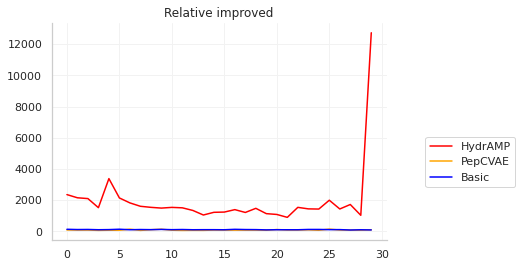

In [34]:
plt.title('Relative improved')
plt.plot([pos_final_results[models[0]][epoch]['relative improvement']  for epoch in range(10, 40)], c='red', label='HydrAMP')
plt.plot([pos_final_results[models[1]][epoch]['relative improvement'] for epoch in range(10, 40)], c='orange', label='PepCVAE')
plt.plot([pos_final_results[models[2]][epoch]['relative improvement'] for epoch in range(10, 40)], c='blue', label='Basic')

plt.legend(bbox_to_anchor=(1.1, 0.5))
plt.show()

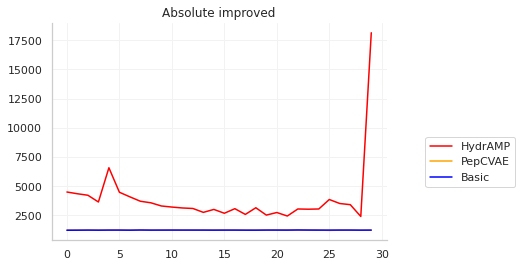

In [35]:
plt.title('Absolute improved')
plt.plot([pos_final_results[models[0]][epoch]['absolute improvement']  for epoch in range(10, 40)], c='red', label='HydrAMP')
plt.plot([pos_final_results[models[1]][epoch]['absolute improvement'] for epoch in range(10, 40)], c='orange', label='PepCVAE')
plt.plot([pos_final_results[models[2]][epoch]['absolute improvement'] for epoch in range(10, 40)], c='blue', label='Basic')

plt.legend(bbox_to_anchor=(1.1, 0.5))
plt.show()

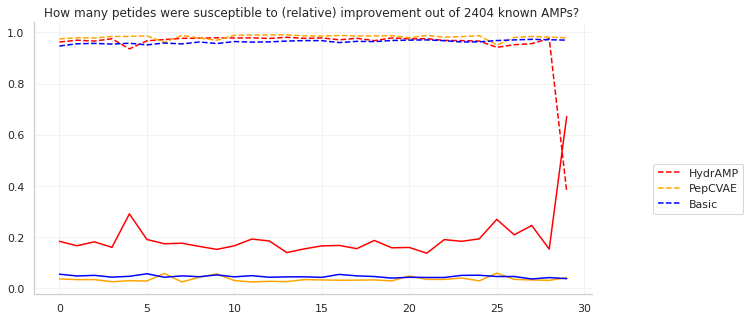

In [36]:
plt.figure(figsize=(10,5))
plt.plot([float(x) for x in hydra_metrics['val_vae_loss_1__amino_acc'].tolist()[10:40]],
         c='red', label='HydrAMP', linestyle='--')
plt.plot([float(x) for x in pepcvae_metrics['val_vae_loss_1__amino_acc'].tolist()[10:40]],
         c='orange', label='PepCVAE', linestyle='--')
plt.plot([float(x) for x in basic_metrics['val_vae_loss_1__amino_acc'].tolist()[10:40]],
         c='blue', label='Basic', linestyle='--')



plt.title('How many petides were susceptible to (relative) improvement out of 2404 known AMPs? ')
plt.plot([pos_final_results[models[0]][epoch]['before relative improvement']/2404 for epoch in range(10, 40)], c='red')
plt.plot([pos_final_results[models[1]][epoch]['before relative improvement']/2404 for epoch in range(10, 40)], c='orange')
plt.plot([pos_final_results[models[2]][epoch]['before relative improvement']/2404 for epoch in range(10, 40)], c='blue')

plt.legend(bbox_to_anchor=(1.1, 0.5))
plt.show()

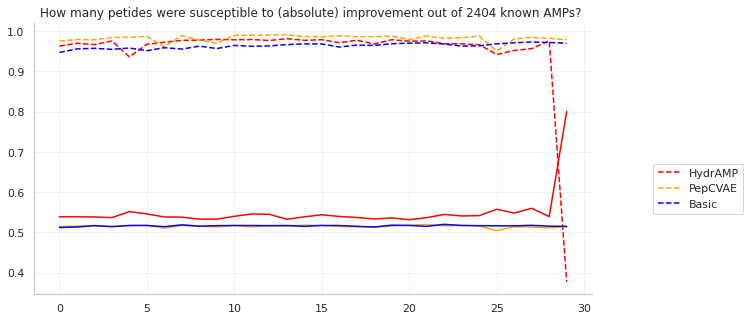

In [37]:
plt.figure(figsize=(10,5))
plt.plot([float(x) for x in hydra_metrics['val_vae_loss_1__amino_acc'].tolist()[10:40]],
         c='red', label='HydrAMP', linestyle='--')
plt.plot([float(x) for x in pepcvae_metrics['val_vae_loss_1__amino_acc'].tolist()[10:40]],
         c='orange', label='PepCVAE', linestyle='--')
plt.plot([float(x) for x in basic_metrics['val_vae_loss_1__amino_acc'].tolist()[10:40]],
         c='blue', label='Basic', linestyle='--')


plt.title('How many petides were susceptible to (absolute) improvement out of 2404 known AMPs? ')
plt.plot([pos_final_results[models[0]][epoch]['before absolute improvement']/2404 for epoch in range(10, 40)], c='red')
plt.plot([pos_final_results[models[1]][epoch]['before absolute improvement']/2404 for epoch in range(10, 40)], c='orange')
plt.plot([pos_final_results[models[2]][epoch]['before absolute improvement']/2404 for epoch in range(10, 40)], c='blue')

plt.legend(bbox_to_anchor=(1.1, 0.5))
plt.show()

# Model selection

In [38]:
def choose_best_epoch(model):
    model_metrics = pd.read_csv(f'../models/{model}/metrics.csv')
    good_epochs = model_metrics.iloc[10:40][model_metrics['val_vae_loss_1__amino_acc'].astype(float)  > 0.95].epoch_no.tolist()
    improved_peptides = [pos_final_results[model][epoch]['before relative improvement']/2404 + \
                         neg_final_results[model][epoch]['before absolute improvement']/2223 \
                         for epoch in good_epochs]
    return good_epochs[np.argmax(improved_peptides)], np.max(improved_peptides)  

In [39]:
best_epochs = {model: [] for model in models}

for model in models:
    best_epochs[model] = choose_best_epoch(model)


In [40]:
best_epochs

{'HydrAMP': (37, 0.27691327170265784),
 'PepCVAE': (35, 0.07166381117690339),
 'Basic': (15, 0.06781844324536329)}

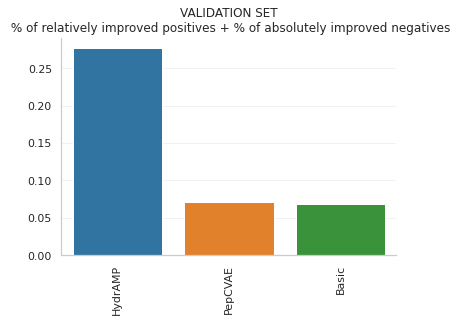

In [41]:
ax = sns.barplot(
    x=model_labels,
    y=[
        pos_final_results[model][int(best_epochs[model][0])]['before relative improvement']/2404 + \
        neg_final_results[model][int(best_epochs[model][0])]['before absolute improvement']/2223 \
        for model in models
    ]
)

ax.set_title('VALIDATION SET\n % of relatively improved positives + % of absolutely improved negatives')
ax.set_xticklabels(model_labels, rotation=90)
plt.show()
    

In [24]:


metrics_to_consider = [
    'before relative improvement',
    'before absolute improvement',
    'relative improvement',
    'absolute improvement',
]

metrics_labels = [
    'How many petides were susceptible to (relative) improvement?',
    'How many petides were susceptible to (absolute) improvement?',
    'Number of uniquely generated peptides during relative improvement procedure (64 attempts per peptide)',
    'Number of uniquely generated peptides during absolute improvement procedure (64 attempts per peptide)',
]

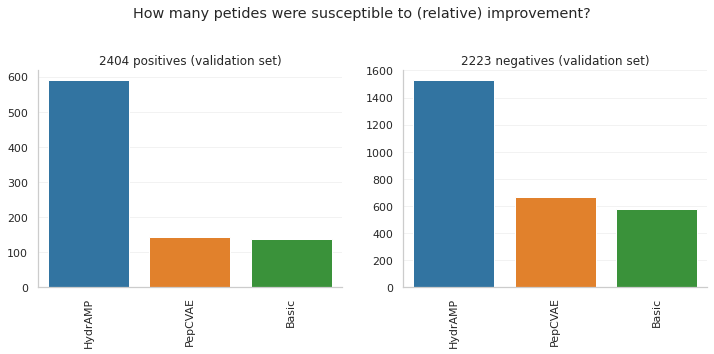

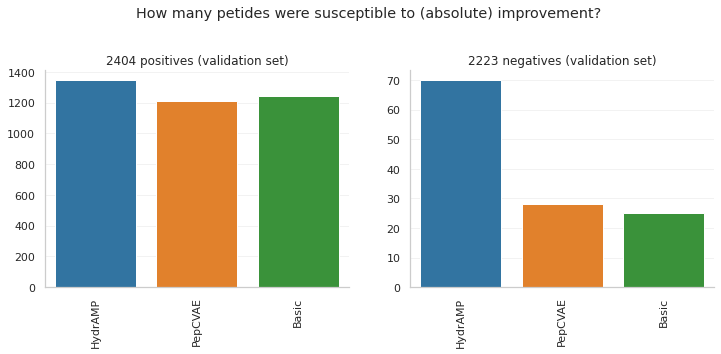

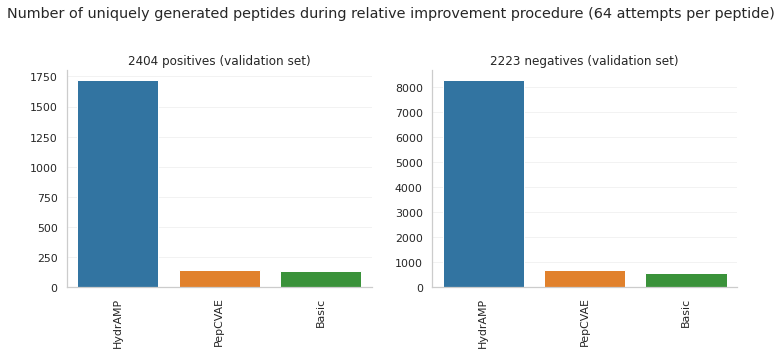

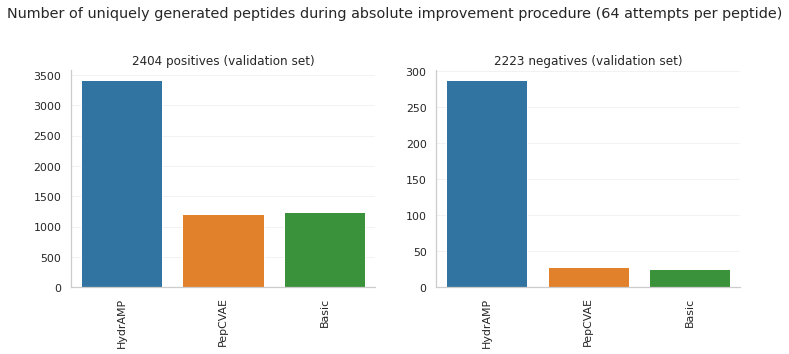

In [43]:
for metric, metric_label in zip(metrics_to_consider, metrics_labels):    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)
    plt.suptitle(metric_label, y=1.1)
    sns.barplot(x=model_labels, y=[pos_final_results[model][int(best_epochs[model][0])][metric] for model in models], ax=ax1)
    sns.barplot(x=model_labels, y=[neg_final_results[model][int(best_epochs[model][0])][metric] for model in models], ax=ax2)

    ax1.set_title('2404 positives (validation set)')
    ax2.set_title('2223 negatives (validation set)')
    ax1.set_xticklabels(model_labels, rotation=90)
    ax2.set_xticklabels(model_labels, rotation=90)
    plt.show()
    

# Test set 

In [16]:
best_epochs = {
    'HydrAMP': 37,
    'PepCVAE': 35,
    'Basic': 15,
}

In [17]:
pos = np.vstack([amp_x_test[amp_y_test == 1], mic_x_test[mic_y_test < 1.5]])
neg = np.vstack([amp_x_test[amp_y_test == 0], mic_x_test[mic_y_test > 1.5]])

print(pos.shape, neg.shape)

pos_amp = amp_classifier_model.predict(pos, verbose=1).reshape(len(pos))
neg_mic = mic_classifier_model.predict(neg, verbose=1).reshape(len(neg))
neg_amp = amp_classifier_model.predict(neg, verbose=1).reshape(len(neg))
pos_mic = amp_classifier_model.predict(pos, verbose=1).reshape(len(pos))

pos = np.vstack([pos] * 64).reshape(-1, 25)
pos_amp = np.vstack([pos_amp] * 64).reshape(-1, 1)
pos_mic = np.vstack([pos_mic] * 64).reshape(-1, 1)
neg = np.vstack([neg] * 64).reshape(-1, 25)
neg_amp = np.vstack([neg_amp] * 64).reshape(-1, 1)
neg_mic = np.vstack([neg_mic] * 64).reshape(-1, 1)

(1319, 25) (1253, 25)
1319/1319 [==============================] - 0s 169us/step


In [18]:
final_pos_results = {}
final_neg_results = {}

In [19]:
for model in tqdm(models):
    epoch = int(best_epochs[model])
    AMPMaster = bms.load_model(f'../models/{model}/{epoch}')
    encoder_model =  AMPMaster.encoder(input_to_encoder)
    decoder_model = AMPMaster.decoder(input_to_decoder)
    if model in ['PepCVAE', 'Basic']:
        new_act = layers.TimeDistributed(
            layers.Activation(activations.softmax),
            name='decoder_time_distribute_activation')
        decoder_model.layers.pop()
        x = new_act(decoder_model.layers[-1].output)
        decoder_model = Model(input=decoder_model.input, output=[x]) 
    final_pos_results[model] = improve(pos, model, epoch, 'pos')
    final_neg_results[model] = improve(neg, model, epoch, 'neg')
    
dump(final_pos_results, f'../results/improvement_PosTest.joblib') 
dump(final_neg_results, f'../results/improvement_NegTest.joblib') 



  0%|          | 0/3 [00:00<?, ?it/s]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 33%|███▎      | 1/3 [00:07<00:15,  7.71s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


 67%|██████▋   | 2/3 [00:15<00:07,  7.74s/it]

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.6023884> temperature


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


['../results/improvement_NegTest.joblib']

In [20]:
pos_final_results = {models: {} for models in models}
neg_final_results = {models: {} for models in models}

In [21]:
for model in models:
        pos_final_results[model]['relative improvement'] = np.unique(
            final_pos_results[model]['rel_improved'], axis=0).shape[0]
        pos_final_results[model]['absolute improvement'] = np.unique(
             final_pos_results[model]['abs_improved'], axis=0).shape[0]
        pos_final_results[model]['before relative improvement'] = np.unique(
            final_pos_results[model]['before_rel_improve'], axis=0).shape[0]
        pos_final_results[model]['before absolute improvement'] = np.unique(
            final_pos_results[model]['before_abs_improve'], axis=0).shape[0]
        
        neg_final_results[model]['relative improvement'] = np.unique(
            final_neg_results[model]['rel_improved'], axis=0).shape[0]
        neg_final_results[model]['absolute improvement'] = np.unique(
             final_neg_results[model]['abs_improved'], axis=0).shape[0]
        neg_final_results[model]['before relative improvement'] = np.unique(
            final_neg_results[model]['before_rel_improve'], axis=0).shape[0]
        neg_final_results[model]['before absolute improvement'] = np.unique(
            final_neg_results[model]['before_abs_improve'], axis=0).shape[0]   

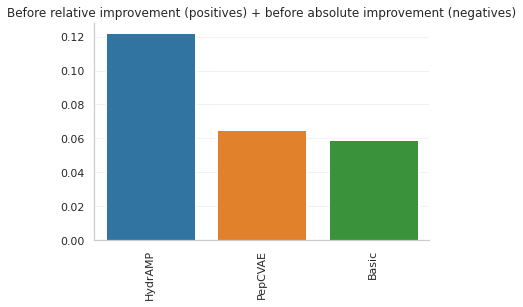

In [22]:
ax = sns.barplot(
    x=model_labels,
    y=[
        pos_final_results[model]['before relative improvement']/1319 + \
        neg_final_results[model]['before absolute improvement']/1253 \
        for model in models])

ax.set_title('Before relative improvement (positives) + before absolute improvement (negatives)')
ax.set_xticklabels(model_labels, rotation=90)
plt.show()
    

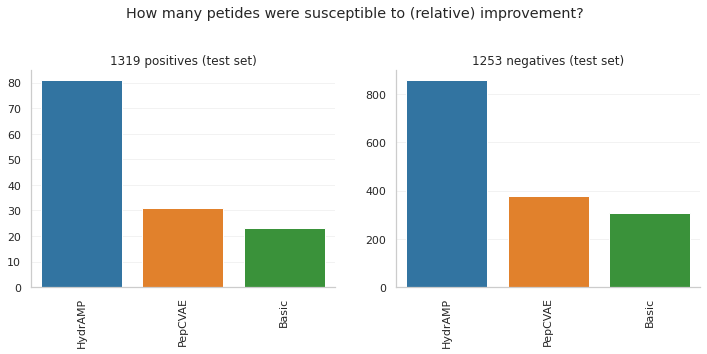

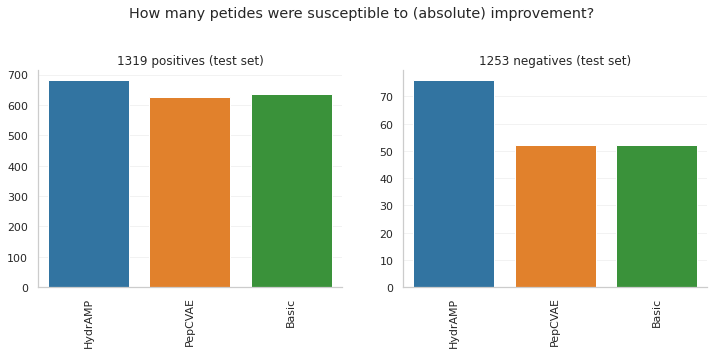

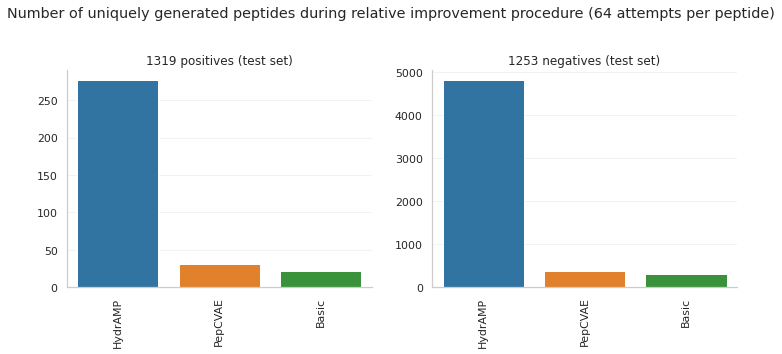

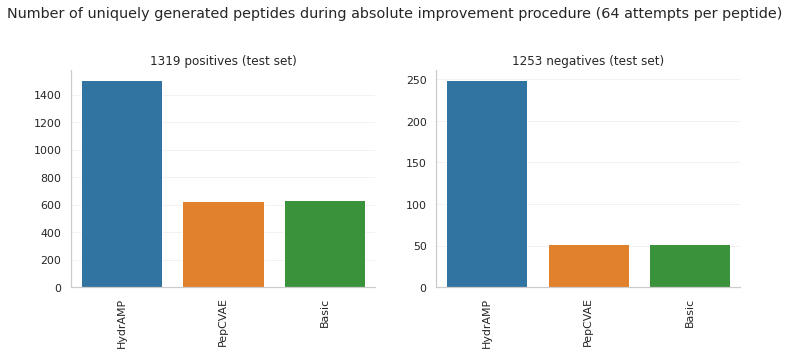

In [25]:
for metric, metric_label in zip(metrics_to_consider, metrics_labels):    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)
    plt.suptitle(metric_label, y=1.1)
    sns.barplot(x=model_labels, y=[pos_final_results[model][metric] for model in models], ax=ax1)
    sns.barplot(x=model_labels, y=[neg_final_results[model][metric] for model in models], ax=ax2)

    ax1.set_title('1319 positives (test set)')
    ax2.set_title('1253 negatives (test set)')
    ax1.set_xticklabels(model_labels, rotation=90)
    ax2.set_xticklabels(model_labels, rotation=90)
    plt.show()
    